In [1]:
# Mount Google Drive
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

# Path to the ZIP file
ZIP_PATH = '/content/drive/MyDrive/online+retail.zip'

# Unzip the file
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/online_retail')  # Extract to folder

# List the extracted files to verify contents
extracted_files = os.listdir('/content/drive/MyDrive/online_retail')
print("Files extracted:", extracted_files)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files extracted: ['Online Retail.xlsx']


In [2]:
# Import necessary libraries
import pandas as pd
from datetime import datetime

# Path to the extracted Excel file
EXCEL_PATH = '/content/drive/MyDrive/online_retail/Online Retail.xlsx'

# Load the Excel file
df = pd.read_excel(EXCEL_PATH)

# Display the first few rows of the dataset
print("First 5 rows:")
display(df.head())

# Check dataset information
print("\nDataset info:")
print(df.info())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Preprocessing
# 1. Drop rows without CustomerID
df = df.dropna(subset=['CustomerID'])

# 2. Remove transactions with negative or zero Quantity
df = df[df['Quantity'] > 0]

# 3. Remove transactions with negative or zero UnitPrice
df = df[df['UnitPrice'] > 0]

# 4. Convert InvoiceDate to datetime type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 5. Check number of remaining rows
print("\nNumber of rows after cleaning:", df.shape[0])

# Check unique customers and items
print("\nNumber of unique customers:", df['CustomerID'].nunique())
print("Number of unique items:", df['StockCode'].nunique())

# Save cleaned dataset for future steps
df_clean = df.copy()


First 5 rows:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None

Missing values per column:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Number of rows after cleaning: 397884

Number of unique customers: 433

In [3]:
# -------------------------------------------
# Step 2: Construct the binary item–transaction matrix
# -------------------------------------------

# Use pivot_table to create a binary matrix
item_transaction_matrix = df_clean.pivot_table(
    index='InvoiceNo',      # rows = invoices
    columns='StockCode',    # columns = items
    values='Quantity',      # fill with quantity first
    aggfunc='sum',          # sum in case the same item appears multiple times in one invoice
    fill_value=0            # missing values -> 0
)

# Convert all positive quantities to 1 (binary presence)
item_transaction_matrix[item_transaction_matrix > 0] = 1

# Optional: check the shape of the matrix
print("Shape of the binary item–transaction matrix:", item_transaction_matrix.shape)

# Display first few rows
display(item_transaction_matrix.head())


Shape of the binary item–transaction matrix: (18532, 3665)


StockCode,10002,10080,10120,10125,10133,10135,11001,15030,15034,15036,...,90214V,90214W,90214Y,90214Z,BANK CHARGES,C2,DOT,M,PADS,POST
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# -------------------------------------------
# Step 3: Streaming simulation – split data into time-based batches
# -------------------------------------------

# Sort the dataset by InvoiceDate (important for streaming simulation)
df_clean = df_clean.sort_values('InvoiceDate')

# Define the batch size (number of transactions per batch)
batch_size = 5000  # you can adjust this number depending on memory and speed

# Create a list to store each batch as a DataFrame
batches = []

# Loop through the dataset and split into batches
for start in range(0, df_clean.shape[0], batch_size):
    end = start + batch_size
    batch = df_clean.iloc[start:end].copy()
    batches.append(batch)

# Check number of batches created
print("Number of batches created:", len(batches))

# Example: display first few rows of the first batch
print("\nFirst batch preview:")
display(batches[0].head())


Number of batches created: 80

First batch preview:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
# -------------------------------------------
# Step 4 (optimized): Matrix monitoring with FD, IPCA, GRP
# -------------------------------------------

import numpy as np
from sklearn.decomposition import IncrementalPCA
from sklearn.random_projection import GaussianRandomProjection

# --- Optimized Frequent Directions function (per batch) ---
def frequent_directions_batch(X, l):
    """
    Approximate Frequent Directions sketch for a batch.
    X: data matrix (rows = transactions, columns = items)
    l: sketch size (number of rows in sketch)
    """
    # Compute SVD of the batch directly
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    s_shrink = np.sqrt(np.maximum(s**2 - s[l-1]**2, 0))
    B = np.dot(np.diag(s_shrink[:l]), Vt[:l, :])
    return B

# Parameters
sketch_size = 50         # FD sketch size
n_components = 50        # IPCA and GRP components
batch_size = 2000        # smaller batch size for faster computation

# Initialize algorithms
ipca = IncrementalPCA(n_components=n_components)
grp = GaussianRandomProjection(n_components=n_components, random_state=42)

# Prepare storage
fd_sketches = []
ipca_transformed = []
grp_transformed = []

# Full set of items for consistent feature alignment
all_items = item_transaction_matrix.columns

# Process first few batches for testing (use all later)
for batch_idx, batch in enumerate(batches[:5]):  # test on first 5 batches first
    # --- Convert batch to binary item–transaction matrix ---
    batch_matrix = batch.pivot_table(
        index='InvoiceNo',
        columns='StockCode',
        values='Quantity',
        aggfunc='sum',
        fill_value=0
    )
    batch_matrix[batch_matrix > 0] = 1
    batch_matrix = batch_matrix.reindex(columns=all_items, fill_value=0)

    X_batch = batch_matrix.values

    # --- Frequent Directions ---
    fd_B = frequent_directions_batch(X_batch, sketch_size)
    fd_sketches.append(fd_B)

    # --- Incremental PCA ---
    ipca.partial_fit(X_batch)
    ipca_transformed.append(ipca.transform(X_batch))

    # --- Gaussian Random Projection ---
    # Only transform (projection matrix fixed)
    if batch_idx == 0:
        # fit only on first batch
        X_batch_grp = grp.fit_transform(X_batch)
    else:
        X_batch_grp = grp.transform(X_batch)
    grp_transformed.append(X_batch_grp)

# --- Check results ---
print("FD sketches:", len(fd_sketches))
print("IPCA batches:", len(ipca_transformed))
print("GRP batches:", len(grp_transformed))
print("Shape of first FD sketch:", fd_sketches[0].shape)
print("Shape of first IPCA batch:", ipca_transformed[0].shape)
print("Shape of first GRP batch:", grp_transformed[0].shape)


FD sketches: 5
IPCA batches: 5
GRP batches: 5
Shape of first FD sketch: (50, 3665)
Shape of first IPCA batch: (313, 50)
Shape of first GRP batch: (313, 50)


In [6]:
# Step 5: Compute analytical metrics (fixed for GRP)
import numpy as np

fd_norms = []
ipca_explained_variance = []
ipca_reconstruction_error = []
grp_projected_norms = []  # instead of reconstruction error

for batch_idx, batch in enumerate(batches[:5]):
    batch_matrix = batch.pivot_table(
        index='InvoiceNo',
        columns='StockCode',
        values='Quantity',
        aggfunc='sum',
        fill_value=0
    )
    batch_matrix[batch_matrix > 0] = 1
    batch_matrix = batch_matrix.reindex(columns=all_items, fill_value=0)

    X_batch = batch_matrix.values

    # --- Frequent Directions ---
    fd_sketch = fd_sketches[batch_idx]
    fd_norms.append(np.linalg.norm(fd_sketch, ord='fro'))

    # --- Incremental PCA ---
    ipca_batch = ipca_transformed[batch_idx]
    ipca_explained_variance.append(np.sum(ipca.explained_variance_ratio_))
    X_reconstructed = ipca.inverse_transform(ipca_batch)
    ipca_reconstruction_error.append(np.linalg.norm(X_batch - X_reconstructed, ord='fro'))

    # --- GRP approximate monitoring (Frobenius norm of projected batch) ---
    grp_batch = grp_transformed[batch_idx]
    grp_projected_norms.append(np.linalg.norm(grp_batch, ord='fro'))

# Display metrics
for i in range(len(fd_norms)):
    print(f"Batch {i+1}:")
    print(f"  FD Frobenius norm: {fd_norms[i]:.2f}")
    print(f"  IPCA explained variance: {ipca_explained_variance[i]:.4f}")
    print(f"  IPCA reconstruction error: {ipca_reconstruction_error[i]:.2f}")
    print(f"  GRP projected Frobenius norm: {grp_projected_norms[i]:.2f}\n")


Batch 1:
  FD Frobenius norm: 38.41
  IPCA explained variance: 0.3025
  IPCA reconstruction error: 87.34
  GRP projected Frobenius norm: 68.82

Batch 2:
  FD Frobenius norm: 38.74
  IPCA explained variance: 0.3025
  IPCA reconstruction error: 80.64
  GRP projected Frobenius norm: 69.45

Batch 3:
  FD Frobenius norm: 36.13
  IPCA explained variance: 0.3025
  IPCA reconstruction error: 75.08
  GRP projected Frobenius norm: 69.62

Batch 4:
  FD Frobenius norm: 38.09
  IPCA explained variance: 0.3025
  IPCA reconstruction error: 73.66
  GRP projected Frobenius norm: 68.60

Batch 5:
  FD Frobenius norm: 33.41
  IPCA explained variance: 0.3025
  IPCA reconstruction error: 61.47
  GRP projected Frobenius norm: 69.61



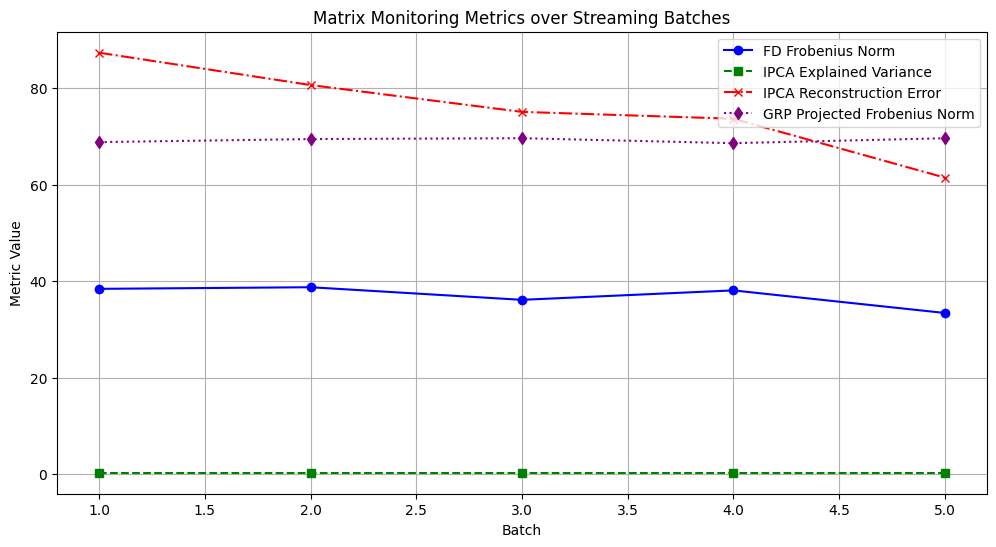

In [7]:
# -------------------------------------------
# Step 6: Plot all metrics for comparison
# -------------------------------------------

import matplotlib.pyplot as plt

batch_indices = np.arange(1, len(fd_norms) + 1)

plt.figure(figsize=(12, 6))

# --- FD Frobenius norm ---
plt.plot(batch_indices, fd_norms, marker='o', linestyle='-', color='blue', label='FD Frobenius Norm')

# --- IPCA metrics ---
plt.plot(batch_indices, ipca_explained_variance, marker='s', linestyle='--', color='green', label='IPCA Explained Variance')
plt.plot(batch_indices, ipca_reconstruction_error, marker='x', linestyle='-.', color='red', label='IPCA Reconstruction Error')

# --- GRP projected Frobenius norm ---
plt.plot(batch_indices, grp_projected_norms, marker='d', linestyle=':', color='purple', label='GRP Projected Frobenius Norm')

plt.xlabel("Batch")
plt.ylabel("Metric Value")
plt.title("Matrix Monitoring Metrics over Streaming Batches")
plt.grid(True)
plt.legend()
plt.show()


In [37]:
# -------------------------------------------
# Step 7: Frequent Pattern Mining
# -------------------------------------------

import sys
import os
import pandas as pd
import time
from mlxtend.frequent_patterns import fpgrowth
import warnings

# Suppress normal Python warnings
warnings.filterwarnings("ignore")

# Store original stdout
original_stdout = sys.stdout
sys.stdout = open(os.devnull, 'w')  # redirect all prints

# Parameters
min_support = 0.05
use_fd_sketch = False
fp_results = []
fp_times = []

# Process first few batches (test on 5 batches for memory)
for batch_idx, batch in enumerate(batches[:5]):
    start_time = time.time()

    # Convert batch to binary item–transaction matrix
    batch_matrix = batch.pivot_table(
        index='InvoiceNo',
        columns='StockCode',
        values='Quantity',
        aggfunc='sum',
        fill_value=0
    )
    batch_matrix[batch_matrix > 0] = 1
    batch_matrix = batch_matrix.reindex(columns=all_items, fill_value=0)

    if use_fd_sketch:
        # Use FD sketch (sketch_size x num_items)
        X_fd = fd_sketches[batch_idx]
        batch_matrix_fd = pd.DataFrame(X_fd > 0, columns=all_items)
        mined_matrix = batch_matrix_fd
    else:
        mined_matrix = batch_matrix

    mined_matrix = mined_matrix.astype(bool)

    try:
        fp_itemsets = fpgrowth(mined_matrix, min_support=min_support, use_colnames=True)
        fp_results.append(fp_itemsets)
        fp_times.append(time.time() - start_time)
    except MemoryError:
        fp_results.append(None)
        fp_times.append(None)

# Restore stdout
sys.stdout.close()
sys.stdout = original_stdout

# Print final results cleanly
for i, itemsets in enumerate(fp_results):
    if itemsets is not None:
        print(f"Batch {i+1}: Found {len(itemsets)} frequent itemsets in {fp_times[i]:.2f} sec")
    else:
        print(f"Batch {i+1}: Memory error")


Batch 1: Found 106 frequent itemsets in 0.16 sec
Batch 2: Found 100 frequent itemsets in 0.09 sec
Batch 3: Found 34 frequent itemsets in 0.08 sec
Batch 4: Found 73 frequent itemsets in 0.07 sec
Batch 5: Found 29 frequent itemsets in 0.07 sec


Anomaly Detection Metrics:
FD Frobenius norm: 38.42
IPCA reconstruction error: 52.78
GRP projected Frobenius norm: 69.29


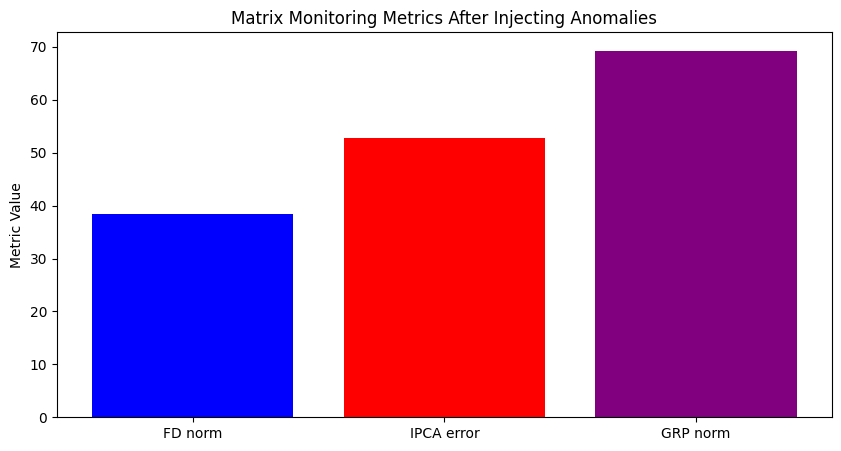

In [11]:
# -------------------------------------------
# Step 8: Anomaly Detection Simulation
# -------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
num_anomalies = 3          # number of artificial anomalous invoices
anomaly_size = 20          # number of items per anomaly

# Copy a batch for anomaly injection
batch_idx = 0
batch = batches[batch_idx].copy()

# Generate artificial anomalies
np.random.seed(42)
unique_items = batch['StockCode'].unique()
anomaly_rows = []

for i in range(num_anomalies):
    anomaly_invoice = {
        'InvoiceNo': f'ANOM_{i+1}',
        'StockCode': np.random.choice(unique_items, size=anomaly_size, replace=False),
        'Quantity': np.random.randint(1, 10, size=anomaly_size),
        'InvoiceDate': pd.Timestamp('2011-01-01'),
        'UnitPrice': np.random.rand(anomaly_size)*5 + 1,
        'CustomerID': 99999,
        'Country': 'United Kingdom'
    }
    anomaly_df = pd.DataFrame(anomaly_invoice)
    anomaly_rows.append(anomaly_df)

# Concatenate anomalies to the batch
batch_with_anomalies = pd.concat([batch] + anomaly_rows, ignore_index=True)

# Convert to binary item–transaction matrix
batch_matrix = batch_with_anomalies.pivot_table(
    index='InvoiceNo',
    columns='StockCode',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)
batch_matrix[batch_matrix > 0] = 1
batch_matrix = batch_matrix.reindex(columns=all_items, fill_value=0)
X_batch = batch_matrix.values

# --- Matrix monitoring (using previous algorithms) ---

# Frequent Directions
fd_B = frequent_directions_batch(X_batch, sketch_size)
fd_norm = np.linalg.norm(fd_B, ord='fro')

# Incremental PCA
ipca.partial_fit(X_batch)
ipca_transformed_batch = ipca.transform(X_batch)
X_reconstructed = ipca.inverse_transform(ipca_transformed_batch)
ipca_error = np.linalg.norm(X_batch - X_reconstructed, ord='fro')

# Gaussian Random Projection
grp_batch = grp.transform(X_batch)
grp_norm = np.linalg.norm(grp_batch, ord='fro')

# --- Display numerical results ---
print("Anomaly Detection Metrics:")
print(f"FD Frobenius norm: {fd_norm:.2f}")
print(f"IPCA reconstruction error: {ipca_error:.2f}")
print(f"GRP projected Frobenius norm: {grp_norm:.2f}")

# --- Visualization ---
plt.figure(figsize=(10,5))
plt.bar(['FD norm', 'IPCA error', 'GRP norm'], [fd_norm, ipca_error, grp_norm], color=['blue','red','purple'])
plt.title("Matrix Monitoring Metrics After Injecting Anomalies")
plt.ylabel("Metric Value")
plt.show()


In [12]:
# -------------------------------------------
# Step 9: Algorithm Performance Summary
# -------------------------------------------

import pandas as pd

# Collect key metrics for comparison
summary_df = pd.DataFrame({
    'Batch': np.arange(1, len(fd_norms)+1),
    'FD_FrobeniusNorm': fd_norms,
    'IPCA_ExplainedVariance': ipca_explained_variance,
    'IPCA_ReconstructionError': ipca_reconstruction_error,
    'GRP_ProjectedNorm': grp_projected_norms,
    'FP_Time_sec': fp_times
})

# Display summary table
summary_df


,Batch,FD_FrobeniusNorm,IPCA_ExplainedVariance,IPCA_ReconstructionError,GRP_ProjectedNorm,FP_Time_sec
0,1,38.408012,0.302497,87.339926,68.816550,0.448882
1,2,38.742162,0.302497,80.642642,69.448007,0.191774
2,3,36.129773,0.302497,75.082968,69.623986,0.145577
3,4,38.085677,0.302497,73.657211,68.595951,0.126867
4,5,33.412302,0.302497,61.471578,69.614302,0.101146
